In [1]:
from odometry_functions_dataloader_stereoimage_dataset import *
from HelperFunctions import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import math
import sympy as sym
from scipy.optimize import least_squares

In [2]:
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.6,
                       minDistance = 7,
                       blockSize = 7,
                       useHarrisDetector=False)
lk_params_1 = dict( winSize  = (15,15),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.03))

thresh = 180
disparity_threshold_low = 10
disparity_threshold_high = 25

## VO using Feature matching with scipy.least_squares

In [3]:
numFrames = 10

left_odom_dataloader = Data_load('left')
right_odom_dataloader = Data_load('right')
left_img_batch = left_odom_dataloader.read_batch(numFrames)
right_img_batch = right_odom_dataloader.read_batch(numFrames)

frame_id = left_odom_dataloader.index-1
direc = left_odom_dataloader.img_path[frame_id].split('/')
cam = StereoCam()
cam.getCameraParams(direc[-3]) # sceneId 00 - 10

nPts_opt = 40             
nPts_track = 40
dist_thr = [5,25]        # Disparity Distance Threshold
currID = 0      # Current Frame ID 
prevID = 0      # Previous Frame ID

# Image Variables : Left Frame, Right Frame, Disparity Map, Disparity Mask
curr = [0,0,0,0] 
prev = [0,0,0,0]

Position = [[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 0]]

f = cam.f
cx = cam.cx
cy = cam.cy
base = cam.base
P1_roi = cam.P_left

left_matcher = cv2.StereoBM_create(\
   numDisparities=160, blockSize=15)
print("Created matcher")

inlier_detection = "Inlier"

frameId = 0
k = 0

print ("CODE STARTED")
while (frameId<=numFrames):
    currID = frameId
    print("---")
    print(frameId)
    curr[0] = left_img_batch[frameId,:,:]
    curr[1] = right_img_batch[frameId,:,:]

    # Calculating Disparity
    curr[2] = np.int16(left_matcher.compute(curr[0],curr[1]))

#     plt.imshow(curr[2]),plt.show() # disparity image

    # Normalizing Disparity Map for Visualization
    disp_view = cv2.normalize(curr[2],None,beta=0,\
            alpha=np.amax(curr[2])/16, norm_type=cv2.NORM_MINMAX);        
    disp_view = np.uint8(disp_view)

    # Dynamic Disparity Mask Thresholding
    temp_thr = dist_thr[0]
    curr[3] = cv2.inRange(\
      disp_view,int(f*base/dist_thr[1]),int(f*base/dist_thr[0]))
    while np.sum(curr[3]) < 20000000:
        temp_thr -= 1
        curr[3] = cv2.inRange(\
          disp_view,int(f*base/dist_thr[1]),int(f*base/temp_thr))
        if temp_thr == 3:
            break

    rows = curr[3].shape[0]
    cols = curr[3].shape[1]
    curr[3][int(3*rows/4):,:] = 0
    curr[3][:int(1*rows/10),:] = 0
    curr[3][:,int(17*cols/20):] = 0

#     plt.imshow(curr[3]),plt.show() # disparity mask

    if currID == prevID + 1:
        Pts_1 = find_keypoints(prev[0],prev[3],20,20,1)
        print("Number of features = ",len(Pts_1))
        Pts_1,Pts_2 = track_keypoints(\
         prev[0],curr[0],Pts_1,nPts_track)

        """
        # VO using solvePnPRansac
        Q = np.float32([[1,0,0,-cx],
            [0,-1,0,cy],
            [0,0,0,-f],
            [0,0,1/base,0 ]])
        points3d = cv2.reprojectImageTo3D(curr[2],Q)
        Pts_1 = np.array(Pts_1,dtype=np.int)
        Pts3D_1 = []
        for x in Pts_1:
            Pts3D_1.append(points3d[x[1],x[0]])
        Pts3D_1 = np.array(Pts3D_1)

        ret = cv2.solvePnPRansac(Pts3D_1,Pts_2,cam.P_left[:3,:3],distCoeffs=None)
        print(ret[1].shape)
        euler1, euler2, euler3 = ret[1][0][0], ret[1][1][0], ret[1][2][0]
        Rmat = cv2.Rodrigues(np.array([ [euler1],[-euler2],[-euler3] ]))[0]
        print(Rmat)
        print(Rmat.shape)
#         Rmat = genEulerZXZMatrix(-ret[1][0][0],ret[1][1][0],-ret[1][2][0])
        Trans = np.array([[ret[2][0][0]],[-ret[2][1][0]],[-ret[2][2][0]]])
        """
        
        
        Pts_1,Pts_2,Pts3D_1,Pts3D_2 = \
         Calc_3DPts(prev[2],Pts_1,curr[2],Pts_2,f,base,cx,cy,16)

        if inlier_detection == "Outlier":
            Pts_1F, Pts_2F, Pts3D_1F, Pts3D_2F = \
             find_bestPts_OR(Pts_1,Pts_2,Pts3D_1,Pts3D_2,nPts_opt)
        elif inlier_detection == "Inlier":
            clique = find_bestPts_ID(Pts3D_1,Pts3D_2,nPts_opt)
            Pts_1F = [Pts_1[i] for i in clique]
            Pts_2F = [Pts_2[i] for i in clique]
            Pts3D_1F = [Pts3D_1[i] for i in clique]
            Pts3D_2F = [Pts3D_2[i] for i in clique]
        else:
            print ("Incorrect Feature Selection Method")
            sys.exit()
        """
        
        """ # To avoid using any of the above Inlier detection methods
        Pts_1F = Pts_1
        Pts_2F = Pts_2
        Pts3D_1F = Pts3D_1
        Pts3D_2F = Pts3D_2
        """
        
        """
        Pts_1F = np.zeros_like(Pts_1F)
        Pts3D_2 = np.zeros_like(Pts3D_2)
        homo = np.ones((len(Pts3D_1F),1))
        Pts_1F = np.hstack((Pts_1F,homo))
        Pts_2F = np.hstack((Pts_2F,homo))
        Pts3D_1F = np.hstack((Pts3D_1F,homo))
        Pts3D_2F = np.hstack((Pts3D_2F,homo))

        # Running the optimization
        dSeed = np.zeros(len(Pts3D_1F))
        optRes = least_squares(mini, dSeed, method='lm', \
              max_nfev=200,args=(Pts3D_1F, Pts3D_2F, Pts_1F,\
              Pts_2F,P1_roi))

#             # Finding Rotation and Translation
        Rmat = genEulerZXZMatrix(\
         optRes.x[0], optRes.x[1], optRes.x[2])
        Trans = np.array(\
         [[optRes.x[3]], [optRes.x[4]], [optRes.x[5]]])
#             print(Pt)
        

#             # Updating the odometry
#             newPosition = trans_pnp
        newPosition = np.vstack(\
         (np.hstack((Rmat,Trans)),[0, 0, 0, 1]))
        print("transformation between the t-1 & t: ")
        print(newPosition)
        Position = np.dot(Position,newPosition)
        print("Position at time t: ")
        print("Ground truth position at time t : ")
        print(Position)
        T_ground_truth = read_ground_truth(direc,frameId)
        print(T_ground_truth)

    prev[0] = curr[0]
    prev[1] = curr[1]
    prev[2] = curr[2]
    prev[3] = curr[3]
    prevID = currID
#     i = i + 1
    frameId = frameId + 1




Created matcher
CODE STARTED
---
0
---
1
Number of features =  273
transformation between the t-1 & t: 
[[-9.53750840e-01 -7.17553195e-02  2.91908390e-01  2.42750043e+01]
 [ 8.75143182e-02 -9.95307843e-01  4.12739844e-02  1.01508769e+01]
 [ 2.87577082e-01  6.49112610e-02  9.55555310e-01  7.94581086e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Position at time t: 
Ground truth position at time t : 
[[-9.53750840e-01 -7.17553195e-02  2.91908390e-01  2.42750043e+01]
 [ 8.75143182e-02 -9.95307843e-01  4.12739844e-02  1.01508769e+01]
 [ 2.87577082e-01  6.49112610e-02  9.55555310e-01  7.94581086e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
 [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
 [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
---
2
Number of features =  273
transformation between the t-1 & 

IndexError: index 10 is out of bounds for axis 0 with size 10

## VO using Feature matching with solvePnPRansac

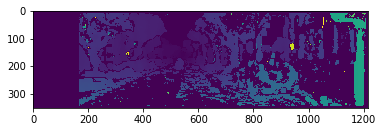

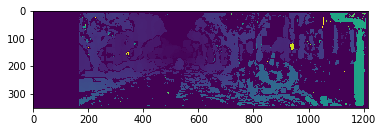

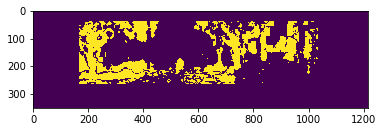

num_useful_matches  20
754 145


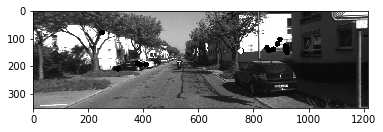

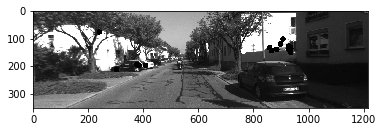

Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99997442e-01  2.08567250e-03  8.74977641e-04  1.00028308e-01]
 [-2.09019156e-03  9.99984316e-01  5.19604267e-03 -4.03051969e-02]
 [-8.64126674e-04 -5.19785825e-03  9.99997442e-01 -6.71382117e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Ground truth position at time t : 
[[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
 [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
 [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


In [15]:
left_odom_dataloader = Data_load('left')
right_odom_dataloader = Data_load('right')
left_img_batch = left_odom_dataloader.read_batch(5)
right_img_batch = right_odom_dataloader.read_batch(5)

frame_id = left_odom_dataloader.index-1
direc = left_odom_dataloader.img_path[frame_id].split('/')
cam = StereoCam()
cam.getCameraParams(direc[-3]) # sceneId 00 - 10

disp1 = compute_disparity_stereoOdomLoader(left_img_batch[0,:,:],right_img_batch[0,:,:],160)
disp2 = compute_disparity_stereoOdomLoader(left_img_batch[1,:,:],right_img_batch[1,:,:],160)
plt.imshow(disp1),plt.show()

features,next_features = match_features_stereoOdomLoader(left_img_batch[0,:,:],left_img_batch[1,:,:],disp1,disp2,thresh,cam,disparity_threshold_low,disparity_threshold_high)



pts_3d_1 = cam.compute_3D_points(left_img_batch[0,:,:],disp1,features,16)

pts_2d_2 = [] # 2D points at time t+1
for i in range(len(features)):
    x = next_features[i,0]
    y = next_features[i,1]
    pts_2d_2.append([x,y])
pts_2d_2 = np.asarray(pts_2d_2)


image = left_img_batch[0,:,:]
next_image = left_img_batch[1,:,:]
for i in range(len(features)):
    if (i==len(features)-2):
        print(int(features[i][0]),int(features[i][1]))
        cv2.circle(image,(int(features[i][0]),int(features[i][1])),10,(255,0,0),-1)
        cv2.circle(next_image,(int(next_features[i][0]),int(next_features[i][1])),10,(255,0,0),-1)
    else :
        cv2.circle(image,(int(features[i][0]),int(features[i][1])),10,(0,0,0),-1)
        cv2.circle(next_image,(int(next_features[i][0]),int(next_features[i][1])),10,(0,0,0),-1)

plt.imshow(image,'gray')
plt.show()

plt.imshow(next_image,'gray')
plt.show()

pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=2)
pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=2)

ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,cam.P_left[:3,:3],distCoeffs=None)
print("Solution found : ",ret[0])

r = genEulerXYZMatrix(ret[1][0][0],ret[1][1][0],ret[1][2][0])
transf_matrix = np.hstack((r,ret[2]))
transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
print("T (from solvePnPRansac) : ")
print(transf_matrix)

print("Ground truth position at time t : ")
T_ground_truth = read_ground_truth(direc,1)
print(T_ground_truth)

## VO using Optical Flow with solvePnPRansac

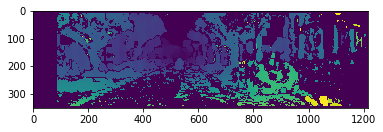

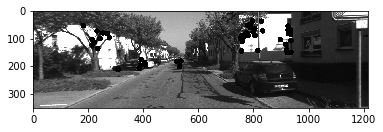

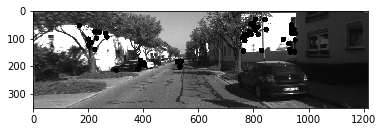

Solution found :  True
T (from solvePnPRansac) : 
[[ 9.99988177e-01  3.09765455e-03  3.74832652e-03  6.95023727e-03]
 [-3.10101288e-03  9.99994795e-01  8.90475354e-04  3.65966972e-02]
 [-3.74554863e-03 -9.02088435e-04  9.99988177e-01 -6.62055869e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Ground truth position at time t : 
[[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
 [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
 [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


In [16]:
left_odom_dataloader = Data_load('left')
right_odom_dataloader = Data_load('right')
left_img_batch = left_odom_dataloader.read_batch(5)
right_img_batch = right_odom_dataloader.read_batch(5)

frame_id = left_odom_dataloader.index-1
direc = left_odom_dataloader.img_path[frame_id].split('/')
cam = StereoCam()
cam.getCameraParams(direc[-3]) # sceneId 00 - 10

disp = compute_disparity_stereoOdomLoader(left_img_batch[0,:,:],right_img_batch[0,:,:],80)
features = find_keypoints_stereoOdomLoader(left_img_batch[0,:,:],disp,feature_params,thresh,cam,disparity_threshold_low,disparity_threshold_high)
features = np.squeeze(features)
# print(features)
# print("Num features : ",len(features))
next_features, status, error = track_keypoints_stereoOdomLoader(left_img_batch[0,:,:],features,left_img_batch[1,:,:],lk_params_1)
status = np.squeeze(status)
features = features[status==1]
next_features = next_features[status==1]
# print("Num features : ",len(features))
# compute 3D points at time t
pts_3d_1 = cam.compute_3D_points(left_img_batch[0,:,:],disp,features,16)

pts_2d_2 = [] # 2D points at time t+1
for i in range(len(features)):
    x = next_features[i,0]
    y = next_features[i,1]
    pts_2d_2.append([x,y])
pts_2d_2 = np.asarray(pts_2d_2)


image = left_img_batch[0,:,:]
next_image = left_img_batch[1,:,:]
for i in range(len(features)):
    cv2.circle(image,(features[i][0],features[i][1]),10,(0,0,0),-1)
    cv2.circle(next_image,(next_features[i][0],next_features[i][1]),10,(0,0,0),-1)

plt.imshow(image,'gray')
plt.show()

plt.imshow(next_image,'gray')
plt.show()

# print(image.shape)

pts_3d_1 = np.expand_dims(pts_3d_1.astype(np.float32),axis=2)
pts_2d_2 = np.expand_dims(pts_2d_2.astype(np.float32),axis=2)

ret = cv2.solvePnPRansac(pts_3d_1,pts_2d_2,cam.P_left[:3,:3],distCoeffs=None)

print("Solution found : ",ret[0])
rmat = cv2.Rodrigues(ret[1])
t = ret[2]

# print(rmat)
# print(t)
r = genEulerXYZMatrix(ret[1][0][0],ret[1][1][0],ret[1][2][0])
transf_matrix = np.hstack((r,ret[2]))
transf_matrix = np.vstack((transf_matrix,np.asarray([0,0,0,1])))
print("T (from solvePnPRansac) : ")
print(transf_matrix)


print("Ground truth position at time t : ")
T_ground_truth = read_ground_truth(direc,1)
print(T_ground_truth)